# Time offsets in `gwrefpy`

This notebook introduces the concept of _time offsets_ and how they are used in `gwrefpy`.

Time offsets are a concept to handle time series with different timestamps. If two time series share the same timestamps, they can be compared directly. If not, we need to introduce a time offset to align them. The offset represents an interval for which all data points will be considered as having the same timestamp.

In the following notebook, we will illustrate this concept with a simple example. The example is provided by section _xx_ in [Strandanger (2024)]().

In [1]:
import gwrefpy as gr
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Data

Let's start by declaring the data we will explore as an example. We create `Well` objects and add to a `Model` object. Finally, we plot the data.

In [2]:
obs_ts = pd.Series(
    index=[
        pd.Timestamp("2023-01-07"),
        pd.Timestamp("2023-02-01"),
        pd.Timestamp("2023-02-25"),
    ],
    data=[11.4, 11.7, 11.8],
    name="obs",
)
ref_ts = pd.Series(
    index=[
        pd.Timestamp("2023-01-08"),
        pd.Timestamp("2023-02-03"),
        pd.Timestamp("2023-02-08"),
        pd.Timestamp("2023-02-25"),
        pd.Timestamp("2023-02-28"),
    ],
    data=[8.9, 9.2, 9.3, 9.3, 9.5],
    name="ref",
)
obs = gr.Well("obs", False, obs_ts)
ref = gr.Well("ref", True, ref_ts)

model = gr.Model("offset test")
model.add_well([obs, ref])

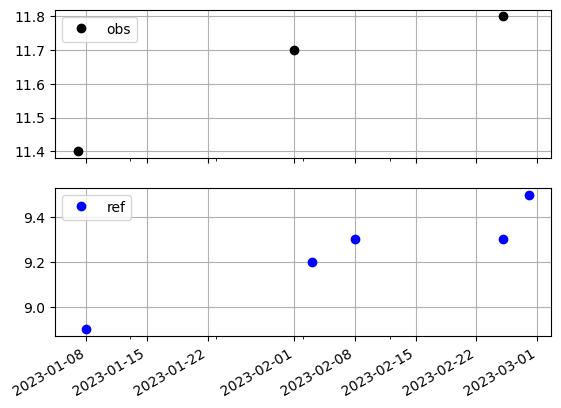

In [3]:
fig, (up, down) = plt.subplots(nrows=2, sharex=True)

obs_ts.plot(ax=up, marker="o", linestyle="", label="obs", color="black")
ref_ts.plot(ax=down, marker="o", linestyle="", label="ref", color="blue")
_ = [ax.legend() for ax in (up, down)]
_ = [ax.grid() for ax in (up, down)]

As we can see, the wells share some timestamps, but not all. In fact, only one timestamp (2023-02-25) is shared between the two wells. The table below shows an outer join between the two wells.

In [4]:
pd.concat([obs_ts, ref_ts], axis="columns", join="outer")

,obs,ref
2023-01-07,11.4,NaN
2023-01-08,NaN,8.9
2023-02-01,11.7,NaN
2023-02-03,NaN,9.2
2023-02-08,NaN,9.3
2023-02-25,11.8,9.3
2023-02-28,NaN,9.5


# Using time offsets

Our two wells have only one shared timestamp, but we know that they have several timestamps that are close to each other. To compare the two time series, we can introduce a time offset.

A time offset is defined as a time interval. All data points within this interval will be considered as having the same timestamp. For example, if we set an offset of 1 day, all data points within 1 day of each other will be considered as having the same timestamp. If multiple data points fall within the same interval, the mean value will be used.

> The offset extends in both directions. For example, if we have a timestamp of 2023-02-25 and an offset of 1 day, all data points between 2023-02-24 and 2023-02-26 will be considered as having the same timestamp.

The offset argument can be given as a string or a `pandas.Timedelta` object. Here you can find the [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html) for more information about the accepted formats.

`gwrefpy` provides a helper function for analyzing multiple time offsets at once: `analyze_time_offsets`. This function takes a list of offsets and computes the number of matching data pairs. Let's see how it works by analyzing offsets of 0, 1, and 3 days.

In [5]:
offsets = ["0D", "1D", "3D"]
results = gr.analyze_offsets(ref, obs, offsets)
results

0D    1
1D    2
3D    3
Name: n_pairs, dtype: int64

Let's plot the width of the offset to understand the results better.

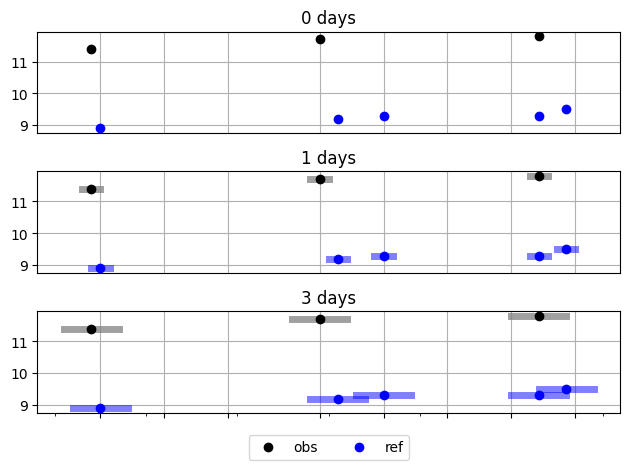

In [6]:
fig, axs = plt.subplots(nrows=len(offsets), ncols=1, sharex=True)

for i, (ax, offset) in enumerate(zip(axs, offsets)):
    for ts, value in obs_ts.items():
        x_start = ts - pd.Timedelta(offset)
        x_end = ts + pd.Timedelta(offset)
        ax.plot([x_start, x_end], [value, value], 
                color="gray", alpha=0.75, linewidth=5)
    
    for ts, value in ref_ts.items():
        x_start = ts - pd.Timedelta(offset)
        x_end = ts + pd.Timedelta(offset)
        ax.plot([x_start, x_end], [value, value], 
                color="blue", alpha=0.5, linewidth=5)
    
    obs_ts.plot(ax=ax, marker="o", linestyle="", label="obs", color="black")
    ref_ts.plot(ax=ax, marker="o", linestyle="", label="ref", color="blue")

    ax.set_title(f"{pd.to_timedelta(offset).days} days")
    ax.grid()
    
    if i < len(offsets) - 1:
        ax.set_xticklabels([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False)

axs[-1].legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

fig.tight_layout()

For this simple example, we can demonstrate that a time offset of 3 days seems reasonable. This offset allows for several matching data pairs, while still being small enough to avoid grouping timestamps that are too far apart.

As mentioned, any points within the offset interval are averaged. The newly constructed timestamps are taken as the mean of the grouped timestamps. Given an offset of 3 days:

- for the first period (January), a data pair is formed because the data point from each well fall within their respective offsets
- for the second period (February), the first data point from the reference well is paired with the data point from the observation well, because their offset intervals intersect
- for the third period (March), **two** data points and their offset interval fall within the offset interval of the single data point from the observation well. This means that a single data pair will be formed between the average of the data points from the reference well, and the single data point from the observation well.



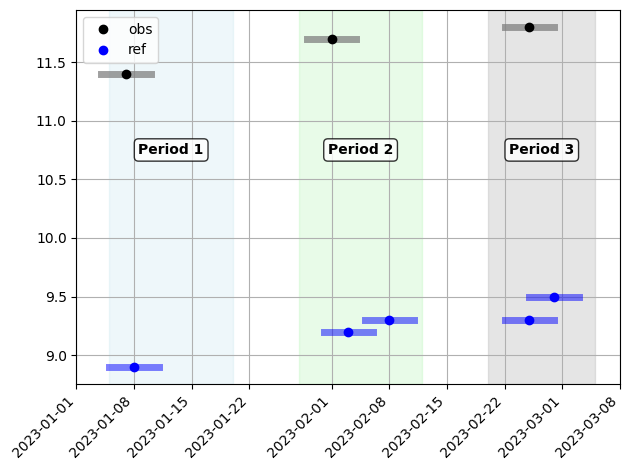

In [7]:
offset = "3D"

fig, ax = plt.subplots()

# Your existing plotting code
for ts, value in obs_ts.items():
    x_start = ts - pd.Timedelta(offset)
    x_end = ts + pd.Timedelta(offset)
    ax.plot([x_start, x_end], [value, value], 
            color="gray", alpha=0.75, linewidth=5)

for ts, value in ref_ts.items():
    x_start = ts - pd.Timedelta(offset)
    x_end = ts + pd.Timedelta(offset)
    ax.plot([x_start, x_end], [value, value], 
            color="blue", alpha=0.5, linewidth=5)

obs_ts.plot(ax=ax, marker="o", linestyle="", label="obs", color="black")
ref_ts.plot(ax=ax, marker="o", linestyle="", label="ref", color="blue")

# Define periods explicitly (adjust dates based on your actual data)
periods = [
    ("2023-01-05", "2023-01-20", "Period 1"),
    ("2023-01-28", "2023-02-12", "Period 2"),
    ("2023-02-20", "2023-03-05", "Period 3")
]

colors = ["lightblue", "lightgreen", "grey"]

for i, (start_date, end_date, label) in enumerate(periods):
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)
    
    ax.axvspan(start, end, alpha=0.2, color=colors[i], zorder=0)
    
    center = start + (end - start) / 2
    y_pos = ax.get_ylim()[1] * 0.9  # Position near top of plot
    ax.text(center, y_pos, label, 
            ha="center", va="center", fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

When fitting these two wells with an offset of 3 days, three data pairs will formed as explained above.

This concludes this notebook on time offsets in `gwrefpy`. Happy fitting!

> More on fitting in [3. Fitting](fitting.ipynb).
